In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.shape

(541909, 8)

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df["CustomerID"].isna().sum()

135080

In [6]:
df = df[pd.notnull(df["CustomerID"])]
df.shape

(406829, 8)

In [7]:
countries = df[["Country", "CustomerID"]].drop_duplicates()
countries.shape

(4380, 2)

In [8]:
countries.head()

,Country,CustomerID
0,United Kingdom,17850.0
9,United Kingdom,13047.0
26,France,12583.0
46,United Kingdom,13748.0
65,United Kingdom,15100.0


In [9]:
countries["Country"].value_counts()

United Kingdom          3950
Germany                   95
France                    87
Spain                     31
Belgium                   25
Switzerland               21
Portugal                  19
Italy                     15
Finland                   12
Austria                   11
Norway                    10
Channel Islands            9
Australia                  9
Netherlands                9
Denmark                    9
Sweden                     8
Cyprus                     8
Japan                      8
Poland                     6
Israel                     4
Greece                     4
USA                        4
Canada                     4
Unspecified                4
EIRE                       3
Malta                      2
Bahrain                    2
United Arab Emirates       2
Iceland                    1
Brazil                     1
European Community         1
Saudi Arabia               1
Czech Republic             1
Lebanon                    1
Singapore     

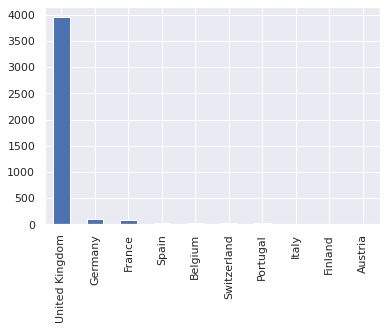

In [10]:
countries["Country"].value_counts()[:10].plot(kind="bar")
plt.show()

In [11]:
uk_df = df[df["Country"] == "United Kingdom"]
uk_df.shape

(361878, 8)

In [12]:
uk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361878 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    361878 non-null  object        
 1   StockCode    361878 non-null  object        
 2   Description  361878 non-null  object        
 3   Quantity     361878 non-null  int64         
 4   InvoiceDate  361878 non-null  datetime64[ns]
 5   UnitPrice    361878 non-null  float64       
 6   CustomerID   361878 non-null  float64       
 7   Country      361878 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB


In [13]:
uk_df.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [14]:
uk_df = uk_df[uk_df["Quantity"] > 0]
uk_df.shape

(354345, 8)

In [15]:
uk_df = uk_df[["CustomerID","InvoiceDate", "InvoiceNo", "Quantity", "UnitPrice"]]

In [16]:
uk_df["TotalPrice"] = uk_df["Quantity"] * uk_df["UnitPrice"]

In [17]:
uk_df["InvoiceDate"].min(), uk_df["InvoiceDate"].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [18]:
PRESENT = datetime.datetime(2011,12,10)
uk_df['InvoiceDate'] = pd.to_datetime(uk_df['InvoiceDate'])

In [19]:
uk_df.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [32]:
snapshot_date = max(uk_df["InvoiceDate"]) + datetime.timedelta(days=1)
rfm = uk_df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "count",
    "TotalPrice": "sum"
})

In [33]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [34]:
rfm.columns = ["recency", "frequency", "monetary"]

In [35]:
#rfm["recency"] = rfm["recency"].astype(int)

In [36]:
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,326,1,77183.60
12747.0,2,103,4196.01
12748.0,1,4596,33719.73
12749.0,4,199,4090.88
12820.0,3,59,942.34


/home/eshban/miniconda3/envs/webenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/eshban/miniconda3/envs/webenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/eshban/miniconda3/envs/webenv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-leve

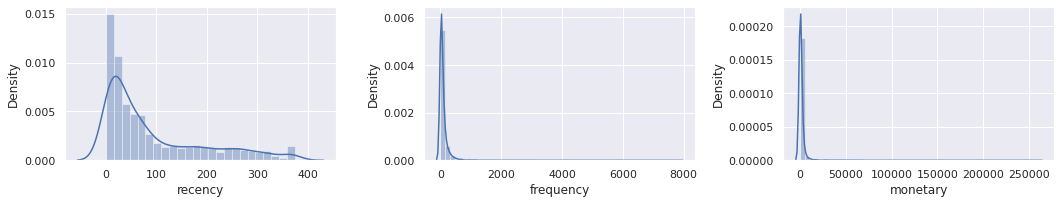

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(15,3))
sns.distplot(rfm['recency'], ax=ax[0])
sns.distplot(rfm['frequency'], ax=ax[1])
sns.distplot(rfm['monetary'], ax=ax[2])
plt.tight_layout()
plt.show()

In [40]:
rfm_fix = pd.DataFrame()
rfm_fix["Recency"] = stats.boxcox(rfm['recency'])[0]
rfm_fix["Frequency"] = stats.boxcox(rfm['frequency'])[0]
rfm_fix["MonetaryValue"] = pd.Series(np.cbrt(rfm['monetary'])).values
rfm_fix.head()

,Recency,Frequency,MonetaryValue
0,10.078722,0.000000,42.576995
1,0.737411,5.291120,16.129176
2,0.000000,10.775845,32.306856
3,1.570965,6.160572,15.993331
4,1.212569,4.580124,9.803983


In [41]:
scaler = StandardScaler()

In [42]:
scaler.fit(rfm_fix)
customers_normalized = scaler.transform(rfm_fix)

In [43]:
print(customers_normalized.mean(axis = 0).round(2)) # [0. -0. 0.]
print(customers_normalized.std(axis = 0).round(2)) # [1. 1. 1.]

[ 0. -0.  0.]
[1. 1. 1.]


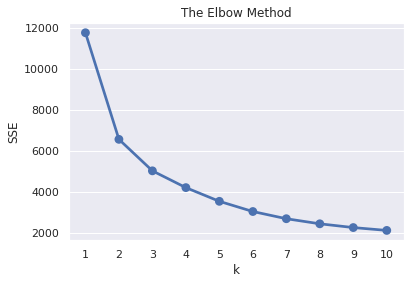

In [45]:
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [46]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(3921,)

In [54]:
rfm["Cluster"] = model.labels_
rfm.head()

,recency,frequency,monetary,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,2
12747.0,2,103,4196.01,2
12748.0,1,4596,33719.73,2
12749.0,4,199,4090.88,2
12820.0,3,59,942.34,1


In [55]:
rfm.shape

(3921, 4)

In [49]:
rfm["Cluster"] = model.labels_
rfm.groupby('Cluster').agg({
    'recency':'mean',
    'frequency':'mean',
    'monetary':['mean', 'count']}).round(2)

recency frequency monetary      
           mean      mean     mean count
Cluster                                 
0        181.57     19.44   371.46  1519
1         42.00     68.38  1014.58  1732
2         19.30    308.04  7443.10   670

/home/eshban/miniconda3/envs/webenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


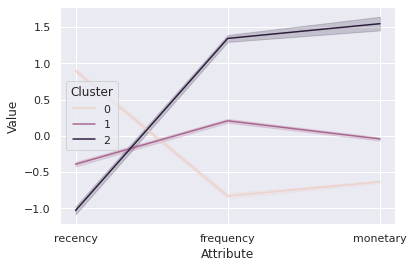

In [52]:
# Create the dataframe
df_normalized = pd.DataFrame(customers_normalized, columns=['recency', 'frequency', 'monetary'])
df_normalized['ID'] = rfm.index
df_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['recency', 'frequency', 'monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)
plt.show()